# <center>⚡️🏁 Quick start - тестируем простое решение</center>

In [22]:
!pip install numpy pandas catboost -q
!ls ../data/ # проверяем наличие данных

In [1]:
import numpy as np
import pandas as pd

## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг  и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - года выпуска машины и начала работы в автопарке 
- `main_city` - город пребывания машины. (Москва или Питер)
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
159,Y-1359331n,Kia Rio,economy,petrol,5.10,2014,61248,2016,54.13,engine_check
303,f11377802P,VW Polo VI,economy,petrol,3.40,2011,1772,2020,68.47,engine_ignition
606,F14265516N,Kia Rio X-line,economy,petrol,3.34,2011,2287,2020,51.62,engine_check


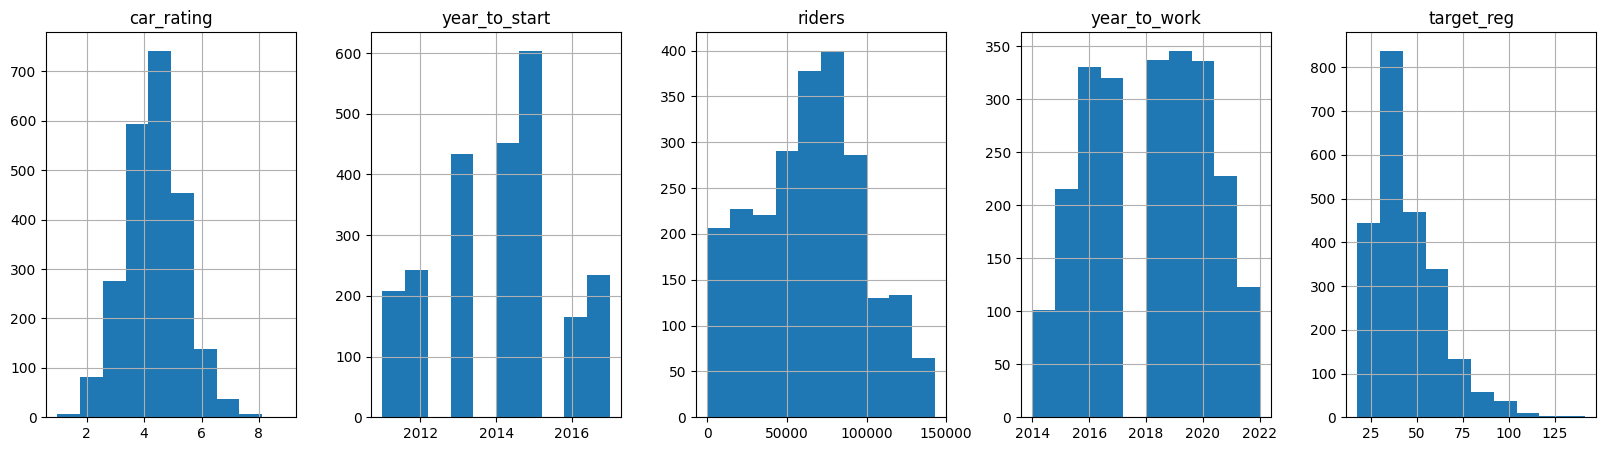

In [2]:
path = '../data/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(20, 5), layout = (-1, 5))
train.sample(3)

In [3]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.947381
std,0.996954,1.685852,33755.012096,2.159484,17.647533
min,0.980000,2011.000000,23.000000,2014.000000,17.640000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.570000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.010000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.720000
max,8.900000,2017.000000,142862.000000,2022.000000,141.130000


In [4]:
path = '../data/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(3)

(1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
677,H-1919071i,Skoda Rapid,economy,petrol,5.96,2017,112411,2016
1158,k-1001578G,Kia Rio,economy,petrol,3.14,2015,74849,2020
1000,W-1663352r,Renault Kaptur,standart,petrol,4.24,2014,63224,2019


## Классифицируем признаки на типы

In [5]:
features2drop = ['car_id'] # то что надо выбросить 
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['car_type', 'fuel_type', 'model'] # категориальные признаки

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


## Обучаем Catboost и делаем прогноз на тест

In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #, mean_squared_error

In [7]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 2.1911361	test: 2.1951349	best: 2.1951349 (0)	total: 53.7ms	remaining: 53.7s
150:	learn: 1.6539682	test: 2.2440578	best: 2.1908935 (6)	total: 890ms	remaining: 5s
300:	learn: 1.2455381	test: 2.3306861	best: 2.1908935 (6)	total: 1.82s	remaining: 4.22s
450:	learn: 0.9685364	test: 2.4038621	best: 2.1908935 (6)	total: 2.81s	remaining: 3.42s
600:	learn: 0.7432300	test: 2.4962387	best: 2.1908935 (6)	total: 3.84s	remaining: 2.55s
750:	learn: 0.5835086	test: 2.5783601	best: 2.1908935 (6)	total: 4.89s	remaining: 1.62s
900:	learn: 0.4589187	test: 2.6654857	best: 2.1908935 (6)	total: 5.93s	remaining: 652ms
999:	learn: 0.3990111	test: 2.7166606	best: 2.1908935 (6)	total: 6.62s	remaining: 0us

bestTest = 2.19089351
bestIteration = 6

Shrink model to first 7 iterations.

 Accuracy: 0.0876068376068376


In [8]:
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы). 


In [9]:
path = '../data/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
19274,x53735682j,B-3210975f,l1g,2020-03-12,1.95,30939,247506,44,131.936643,1,1.388604e+06,0,5.634429,6.206
187533,T19145440f,N-4929388x,r1i,2020-03-12,5.27,58,691,38,45.000000,1,1.238406e+03,0,-20.780520,12.702
7658,i12721459q,A-8582359Y,V1i,2020-01-02,3.71,41,445,75,125.062812,0,2.890629e+03,0,-1.254451,3.910
457504,g21550272S,g-4536331j,p1X,2020-01-31,2.41,35,1744,38,61.000000,2,6.524538e+02,0,2.998132,-3.427
57142,F20963690v,D85554326y,x1N,2020-02-07,3.88,52,515,48,150.122884,1,2.398245e+03,0,-8.815537,-18.533


In [10]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('rating', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [11]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

In [12]:
train.sample(2)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
1067,B22876755u,Smart ForFour,economy,petrol,4.34,2016,94561,2020,28.25,gear_stick,4.584655,9.998077e+06,0.1,112.178337,18.034920,174,169
694,A14861843I,Smart ForTwo,economy,petrol,4.28,2013,38888,2016,42.44,electro_bug,4.653908,2.494076e+07,0.0,200.000000,9.370698,174,174


In [13]:
train.to_csv('../tmp_data/quickstart_train.csv', index=False)

In [ ]:
test.to_csv('../tmp_data/quickstart_tra.csv', index=False)

# Снова обновляем типы фичей

In [14]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


# Обучаем Catboost на новых данных и делаем новый прогноз

In [15]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 1.8867428	test: 1.8889315	best: 1.8889315 (0)	total: 7.08ms	remaining: 7.07s
150:	learn: 0.4109407	test: 0.6689167	best: 0.6685302 (142)	total: 1.92s	remaining: 10.8s
300:	learn: 0.2739907	test: 0.6757269	best: 0.6629107 (177)	total: 3.95s	remaining: 9.18s
450:	learn: 0.1950182	test: 0.6935761	best: 0.6629107 (177)	total: 6.02s	remaining: 7.33s
600:	learn: 0.1443841	test: 0.7192890	best: 0.6629107 (177)	total: 8.07s	remaining: 5.36s
750:	learn: 0.1105230	test: 0.7444843	best: 0.6629107 (177)	total: 10.1s	remaining: 3.35s
900:	learn: 0.0880207	test: 0.7643347	best: 0.6629107 (177)	total: 12.2s	remaining: 1.33s
999:	learn: 0.0771231	test: 0.7761287	best: 0.6629107 (177)	total: 13.4s	remaining: 0us

bestTest = 0.6629106773
bestIteration = 177

Shrink model to first 178 iterations.

 Accuracy: 0.7222222222222222


In [16]:
fi = clf.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,37.390452
1,mean_rating,29.276467
2,rating_min,12.776674
3,model,4.817885
4,car_type,4.339341
5,user_uniq,3.650003
6,user_ride_quality_median,1.742941
7,distance_sum,1.609484
8,riders,1.373459
9,car_rating,1.284999


In [17]:
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


# Что дальше? Зашли решение на Kaggle

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Тип сохранения `Save & Run All (Commit)`
- Жмем окончательно кнопку `Save`